In [1]:
using Pkg
for p in ["Knet", "Plots", "IterTools","PyCall"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end
using DelimitedFiles
using Knet: KnetArray, accuracy, progress, minibatch, cycle, adam, xavier_uniform, progress!
using Plots
using IterTools: ncycle, takenth, take
using Base.Iterators: flatten
using LinearAlgebra

include("utils.jl")
include("models.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


In [2]:
function mytrain!(model, data, epochs, lr, window_size)
    early_stop_counter = 0
    prev_val_loss = 0
    iter = 0
    
    trnloss = []
    valloss = []
    
    flag = true

    function task()     
        
        append!(trnloss, model(data))
        v_loss = val_loss(model, data)
        append!(valloss, v_loss) 
        
        if v_loss >= prev_val_loss
            early_stop_counter = early_stop_counter + 1
        else
            early_stop_counter = 0
        end
        if early_stop_counter == window_size
            flag = false
        end 
        iter = iter + 1
        prev_val_loss = v_loss
        return flag
        
    end
        
    training = adam(model, ncycle(data, epochs), lr=lr)
    progress!(flag = task() for x in (x for (i,x) in enumerate(training)) if flag)
    return 1:iter, trnloss, valloss
end

mytrain! (generic function with 1 method)

In [3]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
    window_size
end

arguments = args(200, 0.01, 5e-4, 16, 0.5, 10)
function val_loss(g::GCN,x,y)
    output = g(x)[:, idx_val]
    nll(output, y[idx_val]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
end  
function val_loss(g::GCN, d)
    mean(val_loss(g,x,y) for (x,y) in d)
end

function test_loss(g::GCN,x,y)
    output = g(x)[:, idx_test]
    nll(output, y[idx_test]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
end  
function test_loss(g::GCN,d)
    mean(test_loss(g,x,y) for (x,y) in d)
end

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 

In [4]:
#####################################################################################################################

In [5]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("cora")

(
  [634 ,    1]  =  1
  [1863,    1]  =  1
  [2583,    1]  =  1
  [3   ,    2]  =  1
  [653 ,    2]  =  1
  [655 ,    2]  =  1
  [2   ,    3]  =  1
  [333 ,    3]  =  1
  [1455,    3]  =  1
  [1667,    3]  =  1
  [1987,    3]  =  1
  [2545,    4]  =  1
  ⋮
  [1537, 2703]  =  1
  [1299, 2704]  =  1
  [642 , 2705]  =  1
  [288 , 2706]  =  1
  [166 , 2707]  =  1
  [170 , 2707]  =  1
  [1474, 2707]  =  1
  [2708, 2707]  =  1
  [166 , 2708]  =  1
  [599 , 2708]  =  1
  [1474, 2708]  =  1
  [2707, 2708]  =  1, 
  [20  ,    1]  =  1.0
  [82  ,    1]  =  1.0
  [147 ,    1]  =  1.0
  [316 ,    1]  =  1.0
  [775 ,    1]  =  1.0
  [878 ,    1]  =  1.0
  [1195,    1]  =  1.0
  [1248,    1]  =  1.0
  [1275,    1]  =  1.0
  [20  ,    2]  =  1.0
  [89  ,    2]  =  1.0
  [150 ,    2]  =  1.0
  ⋮
  [187 , 2708]  =  1.0
  [330 , 2708]  =  1.0
  [448 , 2708]  =  1.0
  [455 , 2708]  =  1.0
  [755 , 2708]  =  1.0
  [775 , 2708]  =  1.0
  [897 , 2708]  =  1.0
  [1023, 2708]  =  1.0
  [1115, 2708]  =  1.0
 

In [6]:
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

GCN(GCLayer(P(Array{Float64,2}(16,1433)), P(Array{Float32,1}(16)), 
  [634 ,    1]  =  1
  [1863,    1]  =  1
  [2583,    1]  =  1
  [3   ,    2]  =  1
  [653 ,    2]  =  1
  [655 ,    2]  =  1
  [2   ,    3]  =  1
  [333 ,    3]  =  1
  [1455,    3]  =  1
  [1667,    3]  =  1
  [1987,    3]  =  1
  [2545,    4]  =  1
  ⋮
  [1537, 2703]  =  1
  [1299, 2704]  =  1
  [642 , 2705]  =  1
  [288 , 2706]  =  1
  [166 , 2707]  =  1
  [170 , 2707]  =  1
  [1474, 2707]  =  1
  [2708, 2707]  =  1
  [166 , 2708]  =  1
  [599 , 2708]  =  1
  [1474, 2708]  =  1
  [2707, 2708]  =  1, NNlib.relu), GCLayer(P(Array{Float64,2}(7,16)), P(Array{Float32,1}(7)), 
  [634 ,    1]  =  1
  [1863,    1]  =  1
  [2583,    1]  =  1
  [3   ,    2]  =  1
  [653 ,    2]  =  1
  [655 ,    2]  =  1
  [2   ,    3]  =  1
  [333 ,    3]  =  1
  [1455,    3]  =  1
  [1667,    3]  =  1
  [1987,    3]  =  1
  [2545,    4]  =  1
  ⋮
  [1537, 2703]  =  1
  [1299, 2704]  =  1
  [642 , 2705]  =  1
  [288 , 2706]  =  1
  [166 , 2

In [7]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

2708-element Array{Int64,1}:
 4
 5
 5
 1
 4
 3
 1
 4
 4
 3
 1
 1
 5
 ⋮
 4
 4
 4
 4
 4
 4
 1
 4
 4
 4
 4
 4

In [8]:
data =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{SparseMatrixCSC{Float32,Int64},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 5 … 4 4], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), SparseMatrixCSC{Float32,Int64}, Array{Int64,1})

In [9]:
iters, trnloss, vallos = mytrain!(model, data, arguments.epochs, arguments.lr, arguments.window_size)

[28, 06:09, 13.18s/i] 


(1:28, Any[3.38962, 1.92896, 1.51943, 1.14639, 1.36483, 1.15939, 1.1423, 1.18645, 1.00033, 0.924057  …  0.534131, 0.503728, 0.46557, 0.434114, 0.399971, 0.375524, 0.355845, 0.339444, 0.328919, 0.321449], Any[3.32646, 2.00461, 1.77516, 1.47719, 1.89569, 1.64642, 1.54585, 1.59529, 1.47812, 1.47955  …  1.47233, 1.48442, 1.514, 1.55183, 1.56869, 1.58985, 1.61655, 1.64246, 1.64849, 1.65282])

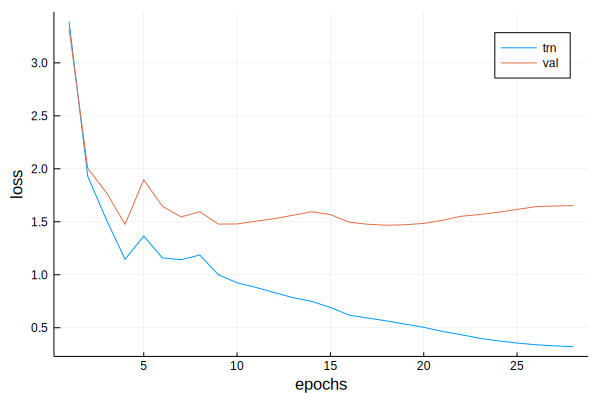

In [10]:
plot(iters, [trnloss, vallos] , xlim=(1:3),labels=[:trn :val :tst], xlabel="epochs", ylabel="loss")

In [11]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [12]:
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.684

In [13]:
png("cora")

In [ ]:
#####################################################################################################################

In [14]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("citeseer")

(
  [629 ,    1]  =  1
  [159 ,    2]  =  1
  [487 ,    2]  =  1
  [1098,    2]  =  1
  [2920,    2]  =  1
  [2934,    2]  =  1
  [3286,    3]  =  1
  [1432,    4]  =  1
  [3220,    4]  =  1
  [468 ,    5]  =  1
  [649 ,    6]  =  1
  [1502,    7]  =  1
  ⋮
  [2912, 3318]  =  1
  [84  , 3319]  =  1
  [3321, 3320]  =  1
  [3320, 3321]  =  1
  [1751, 3322]  =  1
  [3324, 3323]  =  1
  [3323, 3324]  =  1
  [132 , 3325]  =  1
  [269 , 3325]  =  1
  [2821, 3325]  =  1
  [1644, 3326]  =  1
  [34  , 3327]  =  1, 
  [185 ,    1]  =  1.0
  [258 ,    1]  =  1.0
  [363 ,    1]  =  1.0
  [561 ,    1]  =  1.0
  [566 ,    1]  =  1.0
  [598 ,    1]  =  1.0
  [601 ,    1]  =  1.0
  [602 ,    1]  =  1.0
  [638 ,    1]  =  1.0
  [730 ,    1]  =  1.0
  [806 ,    1]  =  1.0
  [817 ,    1]  =  1.0
  ⋮
  [1542, 3327]  =  1.0
  [1619, 3327]  =  1.0
  [2058, 3327]  =  1.0
  [2177, 3327]  =  1.0
  [2231, 3327]  =  1.0
  [2618, 3327]  =  1.0
  [2624, 3327]  =  1.0
  [3231, 3327]  =  1.0
  [3271, 3327]  =  1.0
 

In [15]:
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

GCN(GCLayer(P(Array{Float64,2}(16,3703)), P(Array{Float32,1}(16)), 
  [629 ,    1]  =  1
  [159 ,    2]  =  1
  [487 ,    2]  =  1
  [1098,    2]  =  1
  [2920,    2]  =  1
  [2934,    2]  =  1
  [3286,    3]  =  1
  [1432,    4]  =  1
  [3220,    4]  =  1
  [468 ,    5]  =  1
  [649 ,    6]  =  1
  [1502,    7]  =  1
  ⋮
  [2912, 3318]  =  1
  [84  , 3319]  =  1
  [3321, 3320]  =  1
  [3320, 3321]  =  1
  [1751, 3322]  =  1
  [3324, 3323]  =  1
  [3323, 3324]  =  1
  [132 , 3325]  =  1
  [269 , 3325]  =  1
  [2821, 3325]  =  1
  [1644, 3326]  =  1
  [34  , 3327]  =  1, NNlib.relu), GCLayer(P(Array{Float64,2}(6,16)), P(Array{Float32,1}(6)), 
  [629 ,    1]  =  1
  [159 ,    2]  =  1
  [487 ,    2]  =  1
  [1098,    2]  =  1
  [2920,    2]  =  1
  [2934,    2]  =  1
  [3286,    3]  =  1
  [1432,    4]  =  1
  [3220,    4]  =  1
  [468 ,    5]  =  1
  [649 ,    6]  =  1
  [1502,    7]  =  1
  ⋮
  [2912, 3318]  =  1
  [84  , 3319]  =  1
  [3321, 3320]  =  1
  [3320, 3321]  =  1
  [1751, 3

In [16]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

3327-element Array{Int64,1}:
 4
 2
 6
 6
 4
 2
 4
 1
 4
 6
 3
 5
 3
 ⋮
 4
 3
 5
 5
 2
 2
 1
 4
 4
 4
 2
 6

In [17]:
data =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{SparseMatrixCSC{Float64,Int64},Array{Int64,1}}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 2 … 2 6], 3327, 3327, false, 1, 1:3327, false, (3703, 3327), (3327,), SparseMatrixCSC{Float64,Int64}, Array{Int64,1})

In [18]:
iters, trnloss, vallos = mytrain!(model, data, arguments.epochs, arguments.lr, arguments.window_size)

[14, 22:46, 97.56s/i] 


(1:14, Any[1.44162, 1.25663, 1.05596, 0.888413, 0.804609, 0.70704, 0.614665, 0.55253, 0.495137, 0.44705, 0.408534, 0.375841, 0.351146, 0.330925], Any[1.71725, 1.65411, 1.51988, 1.46943, 1.47818, 1.49797, 1.52155, 1.54037, 1.55983, 1.58298, 1.61492, 1.63645, 1.6517, 1.67596])

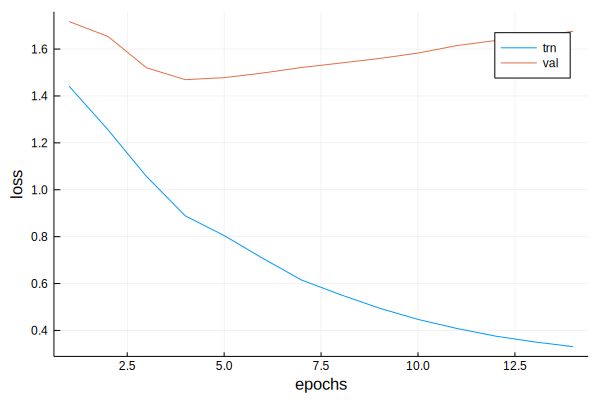

In [19]:
plot(iters, [trnloss, vallos] , xlim=(1:3),labels=[:trn :val :tst], xlabel="epochs", ylabel="loss")

In [20]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [21]:
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.565

In [22]:
png("citeseer")

In [ ]:
#####################################################################################################################

In [23]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("pubmed")

(
  [1379 ,     1]  =  1
  [1545 ,     1]  =  1
  [6093 ,     1]  =  1
  [7637 ,     1]  =  1
  [14443,     1]  =  1
  [2944 ,     2]  =  1
  [8360 ,     2]  =  1
  [10200,     2]  =  1
  [10472,     3]  =  1
  [11486,     3]  =  1
  [15573,     3]  =  1
  [8250 ,     4]  =  1
  ⋮
  [2528 , 19706]  =  1
  [9006 , 19707]  =  1
  [7717 , 19708]  =  1
  [9359 , 19709]  =  1
  [7223 , 19710]  =  1
  [2305 , 19711]  =  1
  [11821, 19712]  =  1
  [2362 , 19713]  =  1
  [12205, 19714]  =  1
  [12279, 19715]  =  1
  [4285 , 19716]  =  1
  [16031, 19717]  =  1, 
  [8    ,     1]  =  0.00499937
  [12   ,     1]  =  0.0480492
  [14   ,     1]  =  0.0129816
  [15   ,     1]  =  0.0172122
  [17   ,     1]  =  0.0175757
  [19   ,     1]  =  0.0101121
  [20   ,     1]  =  0.0261606
  [23   ,     1]  =  0.0127066
  [30   ,     1]  =  0.0208175
  [33   ,     1]  =  0.0154806
  [42   ,     1]  =  0.0215623
  [43   ,     1]  =  0.0170542
  ⋮
  [290  , 19717]  =  0.0265397
  [297  , 19717]  =  0.0224622
 

In [24]:
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

GCN(GCLayer(P(Array{Float64,2}(16,500)), P(Array{Float32,1}(16)), 
  [1379 ,     1]  =  1
  [1545 ,     1]  =  1
  [6093 ,     1]  =  1
  [7637 ,     1]  =  1
  [14443,     1]  =  1
  [2944 ,     2]  =  1
  [8360 ,     2]  =  1
  [10200,     2]  =  1
  [10472,     3]  =  1
  [11486,     3]  =  1
  [15573,     3]  =  1
  [8250 ,     4]  =  1
  ⋮
  [2528 , 19706]  =  1
  [9006 , 19707]  =  1
  [7717 , 19708]  =  1
  [9359 , 19709]  =  1
  [7223 , 19710]  =  1
  [2305 , 19711]  =  1
  [11821, 19712]  =  1
  [2362 , 19713]  =  1
  [12205, 19714]  =  1
  [12279, 19715]  =  1
  [4285 , 19716]  =  1
  [16031, 19717]  =  1, NNlib.relu), GCLayer(P(Array{Float64,2}(3,16)), P(Array{Float32,1}(3)), 
  [1379 ,     1]  =  1
  [1545 ,     1]  =  1
  [6093 ,     1]  =  1
  [7637 ,     1]  =  1
  [14443,     1]  =  1
  [2944 ,     2]  =  1
  [8360 ,     2]  =  1
  [10200,     2]  =  1
  [10472,     3]  =  1
  [11486,     3]  =  1
  [15573,     3]  =  1
  [8250 ,     4]  =  1
  ⋮
  [2528 , 19706]  =  1


In [25]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

19717-element Array{Int64,1}:
 2
 2
 1
 3
 2
 3
 3
 2
 3
 2
 3
 3
 3
 ⋮
 1
 1
 3
 3
 3
 3
 1
 3
 1
 3
 1
 3

In [26]:
data =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{SparseMatrixCSC{Float32,Int64},Array{Int64,1}}}(Float32[0.0 0.0 … 0.107821 0.0; 0.0 0.0 … 0.0 0.0265838; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [2 2 … 1 3], 19717, 19717, false, 1, 1:19717, false, (500, 19717), (19717,), SparseMatrixCSC{Float32,Int64}, Array{Int64,1})

In [27]:
iters, trnloss, vallos = mytrain!(model, data, arguments.epochs, arguments.lr, arguments.window_size)

[1, 34:53, 2093.42s/i] 

InterruptException: InterruptException:

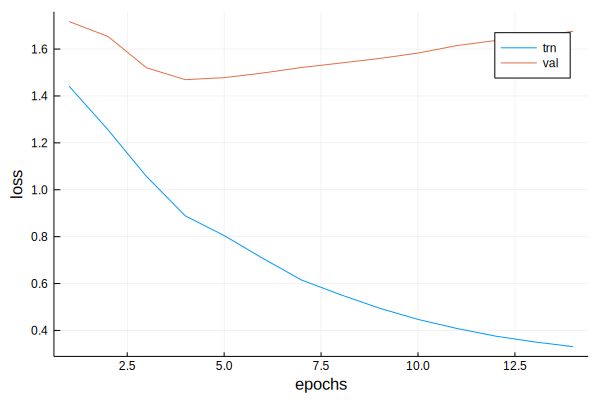

In [28]:
plot(iters, [trnloss, vallos] , xlim=(1:3),labels=[:trn :val :tst], xlabel="epochs", ylabel="loss")

In [29]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.7

In [30]:
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.537

In [31]:
png("pubmed")